In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
updateSavedModel = False # whether or not to update saved (best/final) model

# Read in Data

From preprocess-data.ipynb

In [3]:
# Note on shapes!!!
# For non-combined classes, shape is 7. 
# For combined classes, see nClasses var in preprocessing code to get the appropriate shape!

nClasses = 7

In [4]:
train_dset = tf.data.experimental.load('../data/dsets/train_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, nClasses), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets/val_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, nClasses), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets/test_dset',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, nClasses), dtype=tf.float32, name=None)))

In [5]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # for model evaluation
y_test = [np.where(r==1)[0][0] for r in y_test] # convert from one-hot to integer

# Model

Based on Ogata et al.

In [6]:
import random
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

model_input = tf.keras.Input(shape=(300,171))

# first conv layer
x = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(model_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# res layers
nResLayers = 2 # originally 4

for i in range(nResLayers):
    y = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(x)
    y = tf.keras.layers.Dropout(0.1)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.Dropout(0.1)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.Dropout(0.1)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    z = tf.keras.layers.Conv1D(256,1,strides=2,padding='same')(x)
    z = tf.keras.layers.Dropout(0.1)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    
    x = tf.keras.layers.add([y,z])

# adaptive average pool
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Reshape((256,))(x)

# # final layer
x = tf.keras.layers.Dense(nClasses, activation='softmax')(x)
model_output = tf.keras.layers.Dropout(0.1)(x)

model = tf.keras.Model(model_input, model_output, name="ogata_model")
model.summary()

Model: "ogata_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 171)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 150, 256)     131584      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 256)     0           batch_normalization[0][0]        
________________________________________________________________________________________

In [7]:
# model compile parameters from Ogata et al.
opt = tf.keras.optimizers.Adadelta(learning_rate = 0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

history = model.fit(train_dset,epochs=100,validation_data = val_dset,callbacks=[es])

Epoch 1/100
100/100 [==============================] - 7s 72ms/step - loss: 3.1496 - accuracy: 0.2325 - val_loss: 1.9918 - val_accuracy: 0.1300
Epoch 2/100
100/100 [==============================] - 1s 13ms/step - loss: 2.9582 - accuracy: 0.3700 - val_loss: 2.0417 - val_accuracy: 0.1400
Epoch 3/100
100/100 [==============================] - 1s 13ms/step - loss: 3.0551 - accuracy: 0.4144 - val_loss: 1.9499 - val_accuracy: 0.1850
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 2.7747 - accuracy: 0.4787 - val_loss: 1.7090 - val_accuracy: 0.3050
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 2.8462 - accuracy: 0.4963 - val_loss: 1.5025 - val_accuracy: 0.4400
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 2.6193 - accuracy: 0.5400 - val_loss: 1.4052 - val_accuracy: 0.4850
Epoch 7/100
100/100 [==============================] - 1s 13ms/step - loss: 2.4461 - accuracy: 0.5531 - val_loss: 1.3380 - val_accuracy:

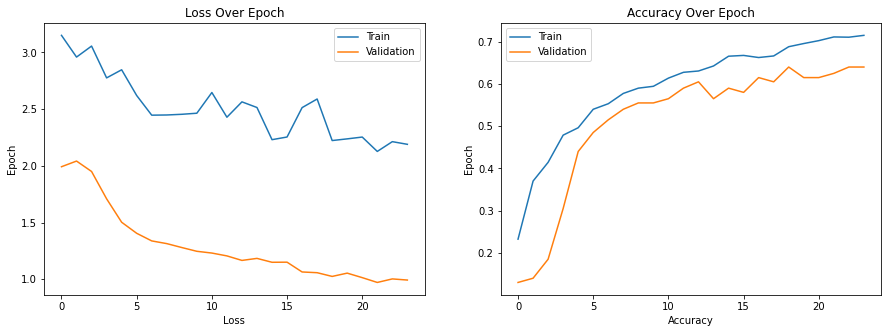

In [9]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

In [10]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 0s 5ms/step - loss: 0.8669 - accuracy: 0.6750
Test accuracy: 0.675


## Regularization Notes

With the base Ogata et al. model, we were getting a train set accuracy of 1.0 (and a val set accuracy of around 0.7). Reducing the number of residual layers from 4 to 2 reduces overfitting slightly (while simplifing the model). Adding a dropout layer with a dropout probability of 0.1 after the final dense layer reduces train set accuracy to 0.88 but doesn't really improve model performance. Similarly, adding a dropout layer after every 1D convolution layer reduces train set accuracy to 0.79 while increasing val set accuracy to 0.75 (though test set accuracy remains at 0.72). In summary, we can reduce overfitting by reducing train set accuracy, but this doesn't result in much val/test set improvement. Confusion matrix does seem to be improved on the whole, with fewer bad accuracies for individual classes.

In [11]:
# save model
if updateSavedModel:
    model.save("trained-models/model_cnn")

# Model Evaluation

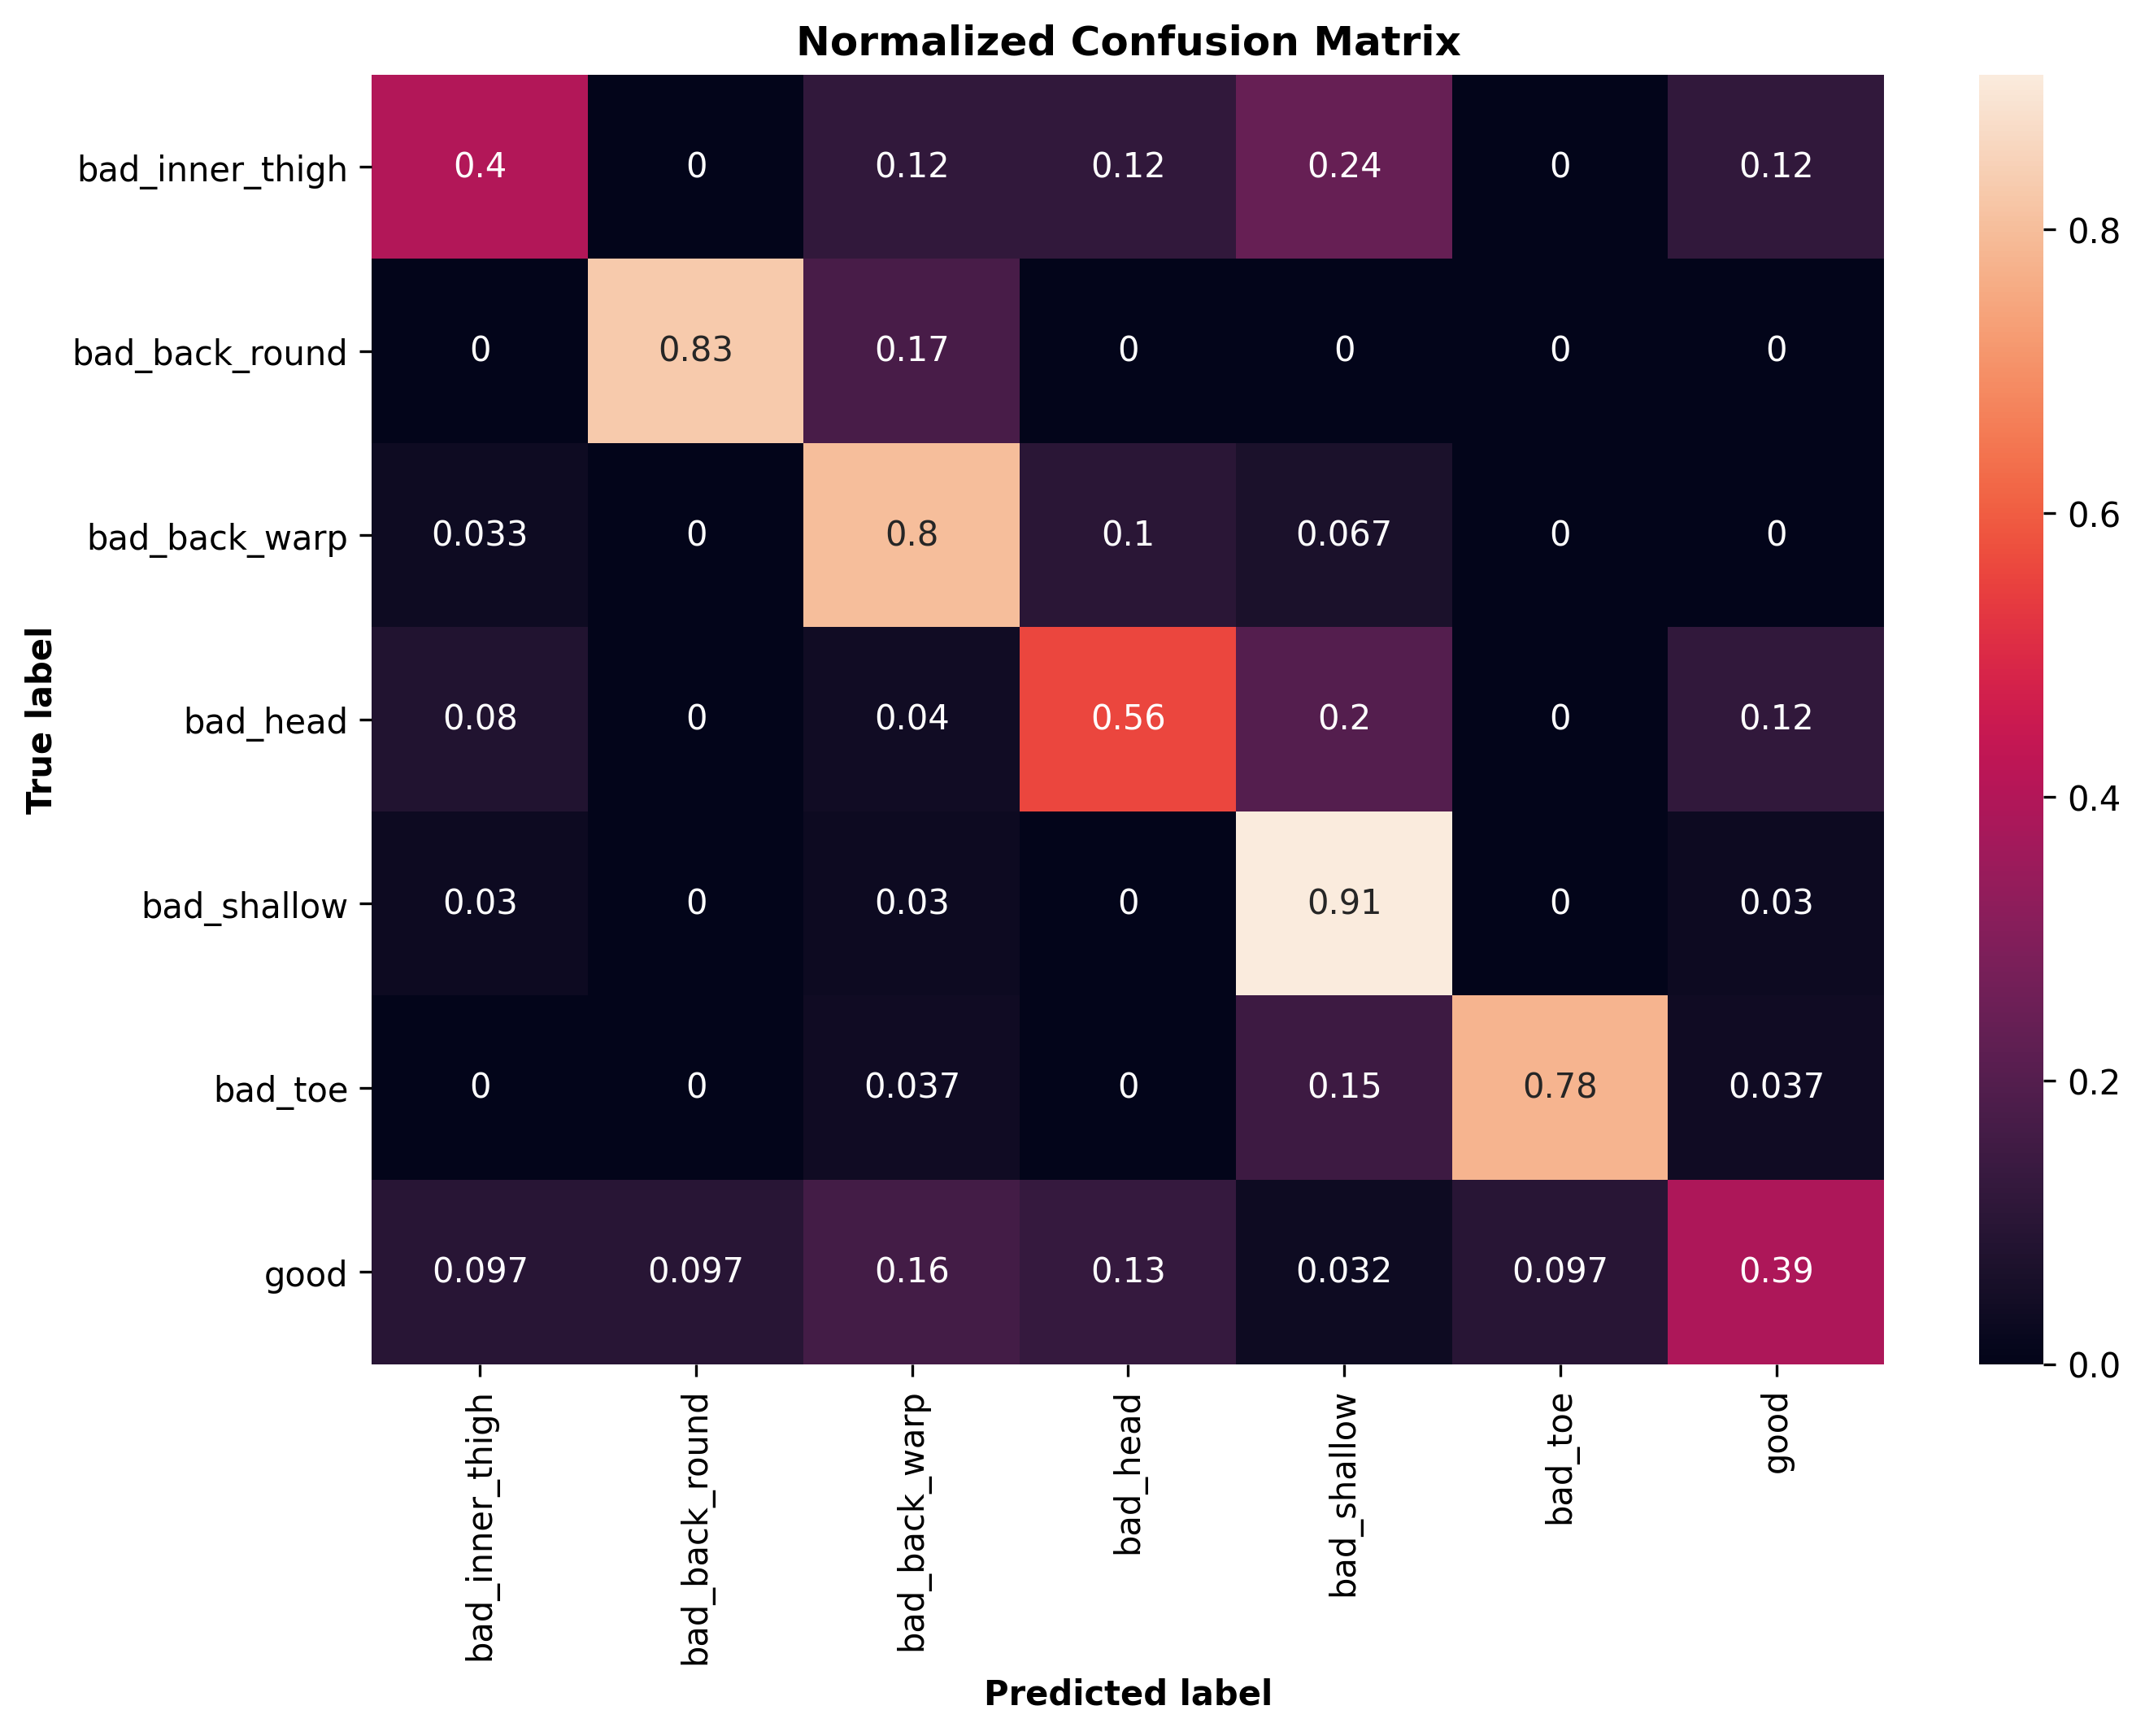


Accuracy: 0.68

Micro Precision: 0.68
Micro Recall: 0.68
Micro F1-score: 0.68

Macro Precision: 0.68
Macro Recall: 0.67
Macro F1-score: 0.66

Weighted Precision: 0.68
Weighted Recall: 0.68
Weighted F1-score: 0.66

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.59      0.40      0.48        25
 bad_back_round       0.89      0.83      0.86        29
  bad_back_warp       0.60      0.80      0.69        30
       bad_head       0.58      0.56      0.57        25
    bad_shallow       0.62      0.91      0.74        33
        bad_toe       0.88      0.78      0.82        27
           good       0.60      0.39      0.47        31

       accuracy                           0.68       200
      macro avg       0.68      0.67      0.66       200
   weighted avg       0.68      0.68      0.66       200

Cohen Kappa Statistic: 0.6192149970708846


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred

##modify display labels!!! depending on which classes are being combined! see last cell of preprocessing notebook!
#display_labels = ['bad_inner_thigh_or_bad_head', 'bad_back_round', 'bad_back_warp', 'bad_shallow', 'bad_toe', 'good'] #new labels for combined matrix (bad head and bad inner thigh combined)
#display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head_or_bad_toe', 'bad_shallow', 'good']
#display_labels = ['bad_inner_thigh', 'bad_back_warp_or_bad_back_round', 'bad_head_or_bad_toe', 'bad_shallow', 'good']
#display_labels = ['bad_inner_thigh', 'bad_back_warp_or_bad_back_round', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']


df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels) 
plt.figure(figsize=(10,7),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=display_labels)
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic:',cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))


In [13]:
# #TO DO: trying to output the classification report into a latex table format (some numbers get messed up due to gaps perhaps...will look more into this for final report)
# classification_report = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'], output_dict = True)
# df = pd.DataFrame(classification_report).transpose()
# print(df.to_latex())